# Robustness

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix


sys.path.append('../')
from src.utils import *
from src.perc import *
from src.generateGraphs import *

np.set_printoptions(legacy='1.25')

fig_directory = '../../Note/Notes/Figures/05_percolation/'

In this notebook we make some simulation on network robustness seeing how it relates to the graph's structure. To do so, we employ synthetic graphs generated from the Erdos-Renyi, Barabasi-Albert and Watts-Strogatz models. 

First we generate a graph and compute some basic graph properties that will be used in the remainder.

In [2]:
n = 10**5 # number of nodes
d_avg = 6 # expected average degree
p_rev = 0.1 # rewiring probability (only used for the Watts-Strogatz)

# select network name between 'ER', 'BA', 'WS'
network_name = 'BA'

if network_name == 'ER':
    A = fastER(n, d_avg)
    g = nx.from_scipy_sparse_array(A)
elif network_name == 'BA':
    g = nx.barabasi_albert_graph(n, int(d_avg/2))
elif network_name == 'WS':
    g = nx.watts_strogatz_graph(n, d_avg, p_rev)

A = nx.adjacency_matrix(g) # adjacency matrix
d = A@np.ones(n) # degree vector
ρB = SpectralRadiusNB(A) # spectral radius of the non-backtracing matrix
ρA = SpectralRadius(A) # spectral radius of the adjacency matrix
κ = np.mean(d**2)/np.mean(d) # kappa parameter for the Molloy-Reed criterion

# nodes and edge sets
nodes, edges = np.array(list(g.nodes())), list(g.edges)
n, E = len(nodes), len(edges)

## Failure

We consider three failure strategies:

* Nodes fail randomly and are removed from the network, together with their edges. In this case we assume that each node fails indipendently with probability $f$.
* Edges fail randomly and are removed from the network. Each edge fails with probability $f$
* Nodes are targeted. A number $N$ (distributed according to a binomial with parameters $n, f$) of nodes is selected and the $N$ nodes with higher degree are removed from the network. For each of these three failure models, we compute the relative size of the giant component after the attack.

In [43]:
pv = 1-np.logspace(-3, 0, 30) # vector of failure probability
idx = np.argsort(d)[::-1] # sort nodes according to the degree

# store the results
GC_node, GC_edge, GC_target = np.zeros(len((pv))), np.zeros(len((pv))), np.zeros(len((pv)))

for i, failure_prob in enumerate(pv):
    print(f'{i+1}/{len(pv)}', end = '\r') # print progress
    
    ##########################################################
    ################ RANDOM NODE FAILURE #####################
    ##########################################################

    # identify the nodes that survived
    not_failed = np.random.binomial(1, failure_prob, n) == 0
    if np.sum(not_failed) > 0:

        # compute the size of the giant component
        g_ = nx.subgraph(g, nodes[not_failed])
        GC_node[i] = len(max(nx.connected_components(g_), key = len))/n

    ##########################################################
    ################ RANDOM EDGE FAILURE #####################
    ##########################################################

    not_failed_idx = np.where(np.random.binomial(1, failure_prob, E) == 0)[0]
    if len(not_failed_idx) > 0:

        # compute the size of the giant component
        EL_ = [edges[a] for a in not_failed_idx]
        g_ = nx.edge_subgraph(g, EL_)
        GC_edge[i] = len(max(nx.connected_components(g_), key = len))/n     


    ##########################################################
    ############### TARGETED NODE FAILURE ####################
    ##########################################################

    nt = np.random.binomial(n, failure_prob)
    if nt < n:
        GC_target[i] = len(max(nx.connected_components(nx.subgraph(g, nodes[idx[nt:]])), key = len))/n

In [44]:
# save 
with open(f'../../Plots/Files/{network_name}_perc.pickle', 'wb') as handle:
    pickle.dump([ρB, ρA, κ, pv, GC_node, GC_edge, GC_target], handle, protocol=pickle.HIGHEST_PROTOCOL)

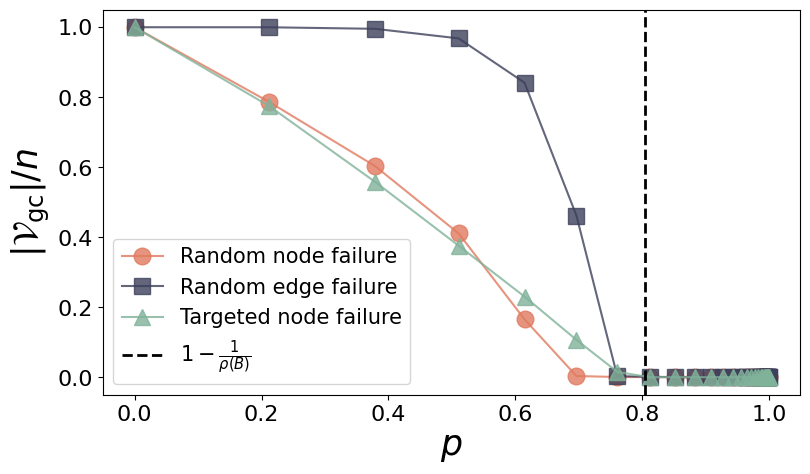

In [34]:
# plot
fig, ax = plt.subplots(1, 1, figsize = (9,5))

ms, alpha = 12, 0.8
ax.plot(pv, GC_node, marker = 'o', color = '#e07a5f', label = 'Random node failure', markersize = ms, alpha = alpha)
ax.plot(pv, GC_edge, marker = 's', color = '#3d405b', label = 'Random edge failure', markersize = ms, alpha = alpha)
ax.plot(pv, GC_target, marker = '^', color = '#81b29a', label = 'Targeted node failure', markersize = ms, alpha = alpha)
ax.axvline(1 - 1/ρB, color = 'k', linestyle = '--', linewidth = 2, label = r'$1 - \frac{1}{\rho(B)}$')
ax.legend(loc = 3, fontsize = 15)
ax.set_xlabel(r'$p$', fontsize = 25)
ax.set_ylabel(r'$|\mathcal{V}_{\rm gc}|/n$', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize = 16)

plt.show();

## Cascade

We now consider the case in which the failure of a node may propagate to its neighbors, causing a failing cascade. We suppose a two-step process: i) each node independently fails with a probability $f$; ii) every node that did not fail, fails if the number of neighbors that failed is at least $\alpha$ times the number of neighbors that did not fail.

For this analysis we will only consider the Watts-Strogatz model. We plot the size of the giant component as a function of $f$ for different choices of $\alpha$.

In [2]:
n = 25000 # number of nodes
d_avg = 20 # expected average degree
p_rev = 0.2 # rewiring probability (only used for the Watts-Strogatz)

g = nx.watts_strogatz_graph(n, d_avg, p_rev)

A = nx.adjacency_matrix(g) # adjacency matrix

# nodes and edge sets
nodes, edges = np.array(list(g.nodes())), list(g.edges)
n, E = len(nodes), len(edges)

In [3]:
alphav = [0.7, 1, 2] # different threshold values to compare
fv = np.linspace(0, 1, 20) # failure probability vector

# store the results
GC_cascade_maj = np.zeros((len(alphav), len((fv))))

for i, alpha in enumerate(alphav):
    for j, failure_prob in enumerate(fv):
        # print progress
        print("[%-25s] %d%%" % ('='*(int((i*len(fv) + j +1)/(len(alphav)*len(fv))*25)-1) + '>', (i*len(fv) + j +1)/(len(alphav)*len(fv))*100), end = '\r')
        
        # identify the nodes that did not fail
        not_failed = propagateMajorityCascade(A, failure_prob, alpha)
        
        if len(not_failed) > 0:
            # compute the size of the giant component
            g_ = nx.subgraph(g, nodes[not_failed])
            GC_cascade_maj[i,j] = len(max(nx.connected_components(g_), key = len))/n

        else: 
            GC_cascade_maj[i,j] = 0


In [4]:
# save 
with open(f'../../Plots/Files/WS_cascade.pickle', 'wb') as handle:
    pickle.dump([fv, alphav, GC_cascade_maj], handle, protocol=pickle.HIGHEST_PROTOCOL)

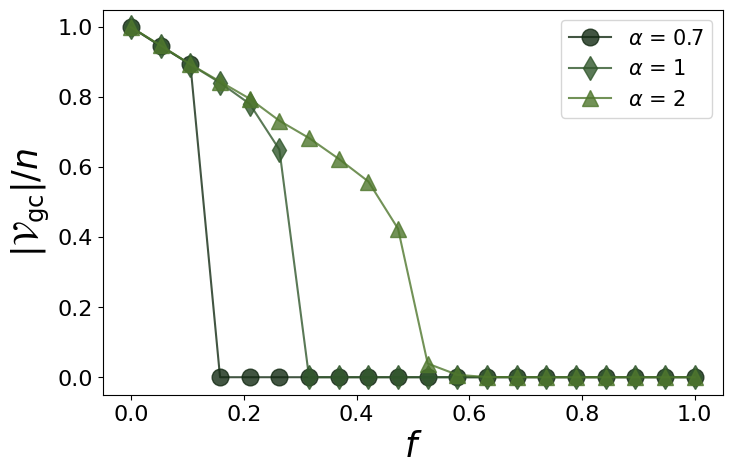

In [6]:
# plot
fig, ax = plt.subplots(1, 1, figsize = (8,5))

ms, alpha = 12, 0.8
colors = ["132a13","31572c","4f772d","90a955","ecf39e"]
colors = ['#' + v for v in colors]
markers = ['o', 'd', '^', 'd']

for i in range(len(alphav)):
    ax.plot(fv, GC_cascade_maj[i], marker = markers[i], color = colors[i], label = r'$\alpha$' + f' = {alphav[i]}', markersize = ms, alpha = alpha)

ax.legend(loc = 1, fontsize = 15)
ax.set_xlabel(r'$f$', fontsize = 25)
ax.set_ylabel(r'$|\mathcal{V}_{\rm gc}|/n$', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize = 16)


plt.show();

### Investigating the effect of clustering on the cascading diffusion

We consider a Watts-Strogatz random graph in which we model a diffusion process. All nodes are set to a state $0$ and one node is arbitrariliy set to $1$. With an iterative process, each node shitches to the state $1$ if at least a fraction $\alpha_i$ of its neighbors is already in that state. We choose the distribtion of $f$ from a negative binomial.

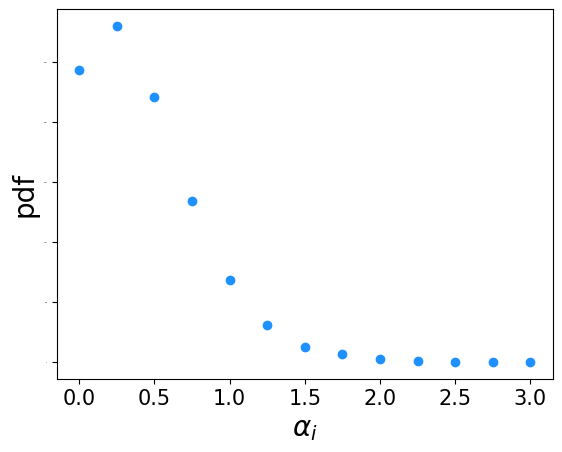

In [2]:
n = 10000 # number of nodes
k = 4 # k parameter in the WS

# vector of susceptibilities
s = np.random.negative_binomial(k, 0.7, n)/k

D = Counter(s)
plt.scatter(D.keys(), D.values(), marker = 'o', color = 'dodgerblue')
plt.xlabel(r'$\alpha_i$', fontsize = 20)
plt.ylabel('pdf', fontsize = 20)
plt.yticks(fontsize = 0)
plt.xticks(fontsize = 15)
plt.show();

We run the cascade for $500$ random initial conditions and average the total adoption as a function of the iterations. We investigate this curve for different reqiring probabilities $p$ in the Watts-Strogatz model.

In [3]:
# rewiring probability vector
pv = [0.1, 0.25, 0.5, 0.75]

n_iter = 50 # number of steps in the cascade
n_samples = 500 # number of repetitions
S = np.zeros(((len(pv), n_samples, n_iter)))

for i, p in enumerate(pv):
    # generate the graph
    g = nx.watts_strogatz_graph(n, 2*k, p)
    A = nx.adjacency_matrix(g)
        
    for j in range(n_iter):
        print("[%-25s] %d%%" % ('='*(int((i*n_iter + j +1)/(n_iter*len(pv))*25)-1) + '>', (i*n_iter + j +1)/(n_iter*len(pv))*100), end = '\r')
        
        # run the process
        S[i,j] = RunCascade(A, s, n_iter)

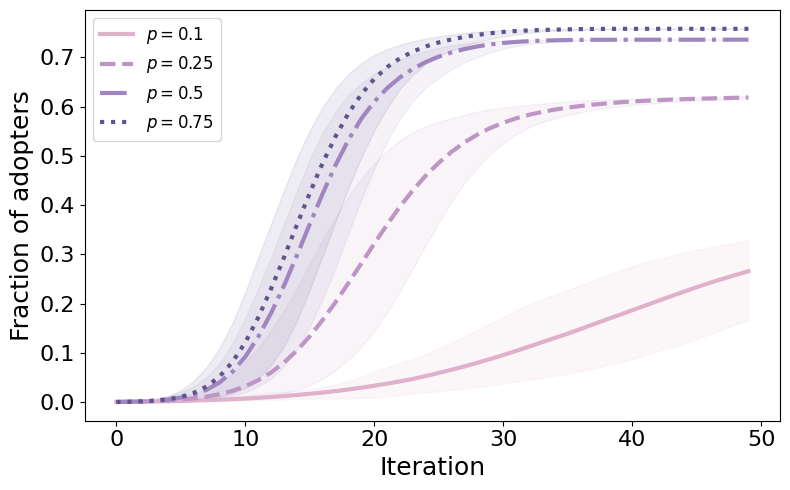

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,5))

colors = ["5e548e","9f86c0","be95c4","e0b1cb"]
colors = ['#'+v for v in colors[::-1]]
linestyles = ['-', '--', '-.', ':']

for i in range(len(pv)):

    S_ = np.array([x for x in S[i] if x[-1] > 0.1])
    if len(S_) == 0:
        S_ = np.zeros(n_iter)
    ax.plot(np.mean(S_, axis = 0), color = colors[i], linewidth = 3, linestyle = linestyles[i], label = f'$p = {pv[i]}$')
    ax.fill_between(np.arange(n_iter), np.percentile(S_, 5, axis = 0), np.percentile(S_, 95, axis = 0), alpha = 0.1, color = colors[i]) 

ax.legend(loc = 2, fontsize = 12)
ax.set_xlabel('Iteration', fontsize = 18)
ax.set_ylabel('Fraction of adopters', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize = 16)

plt.tight_layout()
# plt.savefig(f'{fig_directory}cascade_WS.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

### The strength of weak ties

We suppose to attack the network by removing random edges, or the edges with highest or lowest overlap and see the effect it has on the overall adoption. We recall that the overlap is defined as

\begin{align}
O_{(ij)} = \frac{|\partial_i\cap\partial_j|}{|\partial_i\cup\partial_j|}
\end{align}

In [4]:
n = 1000 # number of nodes
k = 4 # parameter k in the WS
n_iter = 50 # number of iterations in the cascade
ntrials = 200 # number of samples to average
alphav = np.linspace(0, 0.9, 10) # alpha values
s = np.ones(n)*0.125 # np.random.negative_binomial(k, 0.7, n)/k # vector of susceptibilities

S_rdn, S_strong, S_weak = np.zeros(len(alphav)), np.zeros(len(alphav)), np.zeros(len(alphav))
C_rdn, C_strong, C_weak = np.zeros(len(alphav)), np.zeros(len(alphav)), np.zeros(len(alphav))
    
# generate the graph
p = 0.5
g = nx.watts_strogatz_graph(n, 2*k, p)
A = nx.adjacency_matrix(g)

# get the overlap for all edges
EL = pd.DataFrame(np.array(A.nonzero()).T, columns = ['i', 'j'])
EL['overlap'] = EL.apply(lambda x: jaccard_iterators(g.neighbors(x.i), g.neighbors(x.j)), axis = 1).values

for i, alpha in enumerate(alphav):
    print("[%-25s] %d%%" % ('='*(int((i +1)/(len(alphav))*25)-1) + '>', (i +1)/(len(alphav))*100), end = '\r')

    # select random edges and build the corresponding adjacency matrix
    EL_rdn = EL[np.random.binomial(1, alpha, len(EL)) == 0]
    A_rdn = csr_matrix((np.ones(len(EL_rdn.i)), (EL_rdn.i, EL_rdn.j)), shape = (n,n))

    # perform the cascade and store the global clustering coefficient 
    S_rdn[i] = np.max([RunCascade(A_rdn, s, n_iter)[-1] for i in range(ntrials)])
    C_rdn[i] = nx.transitivity(nx.from_scipy_sparse_array(A_rdn))

    ##########################################################################

    # use the same number of edges
    to_keep = len(EL_rdn)

    # target the edges with large overlap (strong ties)
    EL_small_overlap = EL.loc[np.argsort(EL.overlap)[:to_keep]]
    A_small_overlap = csr_matrix((np.ones(len(EL_small_overlap.i)), (EL_small_overlap.i, EL_small_overlap.j)), shape = (n,n))
    S_strong[i] = np.max([RunCascade(A_small_overlap, s, n_iter)[-1] for i in range(ntrials)])
    C_strong[i] = nx.transitivity(nx.from_scipy_sparse_array(A_small_overlap))
    
    # target the edges with small overlap (weak ties)
    EL_large_overlap = EL.loc[np.argsort(EL.overlap)[::-1][:to_keep]]
    A_large_overlap = csr_matrix((np.ones(len(EL_large_overlap.i)), (EL_large_overlap.i, EL_large_overlap.j)), shape = (n,n))
    S_weak[i] = np.max([RunCascade(A_large_overlap, s, n_iter)[-1] for i in range(ntrials)])
    C_weak[i] = nx.transitivity(nx.from_scipy_sparse_array(A_large_overlap))


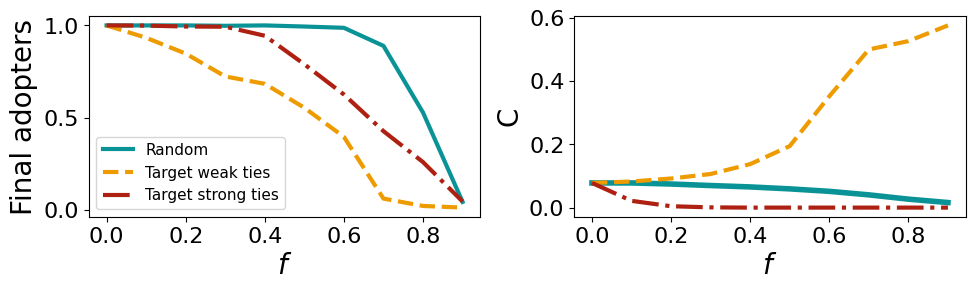

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

colors = ['#0a9396', '#ee9b00', '#ae2012']

ax[0].plot(alphav, S_rdn, label = 'Random', color = colors[0], linewidth = 3, linestyle = '-')
ax[0].plot(alphav, S_weak, label = 'Target weak ties', color = colors[1], linewidth = 3, linestyle = '--')
ax[0].plot(alphav, S_strong, label = 'Target strong ties', color = colors[2], linewidth = 3, linestyle = '-.')

ax[1].plot(alphav, C_rdn, label = 'Random', color = colors[0], linewidth = 4, linestyle = '-')
ax[1].plot(alphav, C_weak, label = 'Target weak ties', color = colors[1], linewidth = 3, linestyle = '--')
ax[1].plot(alphav, C_strong, label = 'Target strong ties', color = colors[2], linewidth = 3, linestyle = '-.')


ax[0].legend(loc = 3, fontsize = 11)
ax[0].set_xlabel('$f$', fontsize = 20)
ax[0].set_ylabel('Final adopters', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize = 16)

ax[1].set_xlabel('$f$', fontsize = 20)
ax[1].set_ylabel('C', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize = 16)

plt.tight_layout()
# plt.savefig(f'{fig_directory}cascade_weak_ties.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();